# Problem Set 4

In [297]:
import pandas as pd
import numpy as np
import scipy.optimize as opt
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read in the data
df = pd.read_stata('PS4_data.dta')
df.head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce
0,1,1967,1,Head,1200.0,2000.0,NaN,NaN,0,NaN,...,5614.0,1.0,2.0,52.0,46.0,1.0,2.0,8.0,8.0,0.0
1,2,1967,2,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,56.0,57.0,1.0,2.0,3.0,3.0,0.0
2,3,1967,3,Head,0.0,0.0,NaN,NaN,0,NaN,...,0.0,1.0,2.0,77.0,64.0,1.0,2.0,NaN,3.0,0.0
3,4,1967,4,Head,1560.0,0.0,NaN,NaN,6,1.0,...,3280.0,1.0,2.0,45.0,44.0,1.0,2.0,8.0,5.0,0.0
4,5,1967,5,Head,2500.0,2000.0,NaN,NaN,3,1.0,...,7900.0,1.0,2.0,24.0,22.0,1.0,2.0,10.0,9.0,0.0


Select only 
1. male heads of household 
2. who are between 25 and 60 years of age 
3. and earn wages > \$7/hr.

In [63]:
df_model = df[(df['hsex']==1) & (df['age']>=25) & (df['age']<=60)
              & (df['hlabinc']/df['hannhrs']>7) & (df['hannhrs'] != 0)]
# to avoid problems, I exclude the head working for 0 hour

In [64]:
# check the data is selected correctly
df_model['hsex'].describe()

count    57477.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: hsex, dtype: float64

In [65]:
df_model['age'].describe()

count    57477.000000
mean        39.224247
std          9.578915
min         25.000000
25%         31.000000
50%         38.000000
75%         47.000000
max         60.000000
Name: age, dtype: float64

In [66]:
df_model[df_model['hannhrs']==0].head()

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce


In [67]:
# add a new coloumn 'hlhrinc' for hourly labour income of the head
df_model['hlhrinc'] = df['hlabinc']/df['hannhrs']
df_model['hlhrinc'].describe()

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    57477.000000
mean        24.306021
std         25.154232
min          7.000252
25%         13.947624
50%         19.905161
75%         27.787226
max       1717.330322
Name: hlhrinc, dtype: float64

In [68]:
# build a new dataframe to check hourly income
df_checkinc = pd.DataFrame(df_model, columns=['hannhrs','hlhrinc','hlabinc'])

In [69]:
df_checkinc[df_checkinc['hlhrinc']<7]

,hannhrs,hlhrinc,hlabinc


It seems that I have filtered out all the heads with income less than 7 dollars per hour

In [70]:
df_checkinc[df_checkinc['hlhrinc']==df_checkinc['hlhrinc'].max()]

,hannhrs,hlhrinc,hlabinc
34947,32.0,1717.330322,54954.570312


The model is:
$$ln(w_{i,t}) = \alpha + \beta_1 Educ_{i,t} + \beta_2 Age_{i,t} + \beta_3 Age_{i,t}^2 + \beta_4 Black_{i,t} + \beta_5 Hispanic_{i,t} + \beta_6 OtherRace_{i,t} + \varepsilon_{i,t}$$

The variables names are as follows:
* `w` = wage of individual i in survey year t
* `Educ` = education in years
* `Age` = age in years
* `Black, Hispanic, OtherRace` = dummy variables for race = Black, Hispanic, Not ∈ {White, Black, Hispanic}

In [71]:
df_model['lnw'] = np.log(df_model['hlabinc'])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
'''
create a new column 'race', 
in which race of the head is black will be assigned as 'Black',
race of the head is hispanic will be assigned as 'Hispanic',
people rather than white, black or hispanic will be assigned as 'Other race'
'''
def race(x):
    if x == 2:
        return 'Black'
    elif x == 5:
        return 'Hispanic'
    elif x == 1:
        return 'White'
    else:
        return 'Other race'
    
df_model['race']= df_model['hrace']
df_model['race'] = df_model['hrace'].apply(lambda x: race(x))

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
# check the value is assigned correctly
df_model[df_model['hrace']==2]['race'].head()

11196    Black
11417    Black
11436    Black
11548    Black
11640    Black
Name: race, dtype: object

In [98]:
df_model[df_model['hrace']==1]['race'].head()

11161    White
11164    White
11166    White
11173    White
11175    White
Name: race, dtype: object

In [111]:
df_model[df_model['hrace']==3]['race'].head()

11268    Other race
11277    Other race
11350    Other race
11937    Other race
12006    Other race
Name: race, dtype: object

In [112]:
df_model[df_model['hrace']==5]['race'].head()

Series([], Name: race, dtype: object)

In [113]:
# check what's the situation in the raw data
df[df['hrace']==5]

,id68,year,intid,relhh,hannhrs,wannhrs,hlabinc,wlabinc,nochild,wrace,...,redpregovinc,hsex,wsex,age,wage,hpersno,wpersno,hyrsed,wyrsed,pce


There is no Hispanic people in the raw data, so there is no error here.

In [114]:
df_dummies = pd.get_dummies(df_model['race'])

In [115]:
df_dummies.head()

,Black,Other race,White
11161,0,0,1
11164,0,0,1
11166,0,0,1
11173,0,0,1
11175,0,0,1


In [116]:
df_model['race'].head()

11161    White
11164    White
11166    White
11173    White
11175    White
Name: race, dtype: object

In [118]:
df_model['age2'] = np.square(df_model['age'])

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
df_model[['age','age2']].head()

,age,age2
11161,51.0,2601.0
11164,55.0,3025.0
11166,25.0,625.0
11173,39.0,1521.0
11175,36.0,1296.0


In [125]:
# make a new dataframe that only keeps the variable needed in the model
df_variables1 = pd.DataFrame(df_model, columns=['id68','year','lnw','hyrsed','age','age2','hrace'])
df_variables = pd.concat([df_variables1,df_dummies], axis=1)

In [126]:
df_variables.head()

,id68,year,lnw,hyrsed,age,age2,hrace,Black,Other race,White
11161,402,1971,11.049758,12.0,51.0,2601.0,1.0,0,0,1
11164,461,1971,10.028399,5.0,55.0,3025.0,1.0,0,0,1
11166,1126,1971,10.286634,16.0,25.0,625.0,1.0,0,0,1
11173,284,1971,11.250072,16.0,39.0,1521.0,1.0,0,0,1
11175,50,1971,10.372496,12.0,36.0,1296.0,1.0,0,0,1


In [127]:
'''
Since there is no hispanic in original database, 
but Hispanic is a dummy variable,
I will add a column named 'Hispanic' and assign all the value to 0
''' 
df_variables['Hispanic'] = 0

In [128]:
df_variables.head()

,id68,year,lnw,hyrsed,age,age2,hrace,Black,Other race,White,Hispanic
11161,402,1971,11.049758,12.0,51.0,2601.0,1.0,0,0,1,0
11164,461,1971,10.028399,5.0,55.0,3025.0,1.0,0,0,1,0
11166,1126,1971,10.286634,16.0,25.0,625.0,1.0,0,0,1,0
11173,284,1971,11.250072,16.0,39.0,1521.0,1.0,0,0,1,0
11175,50,1971,10.372496,12.0,36.0,1296.0,1.0,0,0,1,0


In [141]:
def setup(year, dataset):
    df_t = dataset[dataset['year']==year]
    y = df_t['lnw']
    X = pd.DataFrame(df_t, columns=['hyrsed','age','age2','Black','Hispanic','Other race'])
    
    return y, X
    

I choose poisson distribution to be the probability distribution that generates the data. Therefore, the function is:
$$
f(x) = \frac{u^y}{y!} e^{-u}
$$
In the regression model, 
$$
u_i = \beta_0 + \beta_1 x_i1 + \beta_2 x_i2 + …… + \beta_n x_in
$$

The joint pmf is:
$$
f(y_1, y_2, ...., y_n| x_1, x_2, .... , x_n; \beta) = \prod^n_{i=1} \frac{u_i^{y_i}}{y_i!} e^{-u_i}
$$

The likelihood function is the same as the joint pmf, but treats the parametes $\beta$ as a random variable and takes the observations $(y_i,x_i)$ as given
$$\mathcal{L}(\beta|y_1, y_2, ……, y_n; x_1, x_2, .... , x_n) = \prod^n_{i=1} \frac{u_i^{y_i}}{y_i!} e^{-u_i} \\
= f(y_1, y_2, ...., y_n| x_1, x_2, .... , x_n; \beta) $$

<br>
  
$$
\hat \beta = \mathop{max}\limits_{\beta} \mathcal{L}(\beta) \\
\hat \beta = \mathop{max}\limits_{\beta}log\mathcal{L}(\beta) \\
= \mathop{max}\limits_{\beta}(\sum^n_{i=1} y_i log u_i - \sum^n_{i=1} u_i - \sum^n_{i=1} log y!)
$$

In [300]:
def reg(year, dataset, beta0):
    
    y, X = setup(year, dataset)
    
    def costFunction(beta, y, X):
        
        
        n, k = X.shape
        y = np.array(y)
        y = y.reshape(n,1)
        beta = beta.reshape(k,1)
        u = X@beta
        
        # return the function that we want to minimize
        return -np.sum(y * np.log(u) - u - np.log(factorial(y)))
    
    res = opt.minimize(costFunction, beta0, args=(y,X), method ='L-BFGS-B',
                     tol=1e-15, options={'maxiter': 5000}) 
    return res

In [303]:
t = [1971, 1980, 1990, 2000]
# randomly choose the initial guess
beta_initial = np.random.rand(6)

beta1 = []

for year in t:
    res = reg(year, df_variables,beta_initial)
    print('The estimate for year {} is: \n {}'.format(year, res.x))
    
    coef1 = res.x[0]*100
    
    # interpret the coefficient beta1
    print('If the years of eduction increase by 1, the annual income of the head will increase by {}%\n'.format(coef1))
    
    beta1.append(coef1)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in log
  from ipykernel import kernelapp as app
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


The estimate for year 1971 is: 
 [ 0.45597721  0.0051746  -0.16198892  0.24718822  0.00896086  0.94945311]
If the years of eduction increase by 1, the annual income of the head will increase by 45.59772050736522%

The estimate for year 1980 is: 
 [ 0.45466351  0.00416802 -0.1619548   0.2471872   0.00896086  0.94945461]
If the years of eduction increase by 1, the annual income of the head will increase by 45.466350553183226%

The estimate for year 1990 is: 
 [ 0.45436018  0.00408386 -0.16195017  0.24719266  0.00896086  0.9494593 ]
If the years of eduction increase by 1, the annual income of the head will increase by 45.43601835759395%

The estimate for year 2000 is: 
 [ 0.45527557  0.00545288 -0.16199017  0.24719753  0.00896086  0.94944712]
If the years of eduction increase by 1, the annual income of the head will increase by 45.52755731073274%



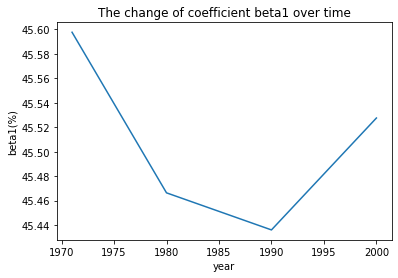

In [304]:
plt.plot(t, beta1)
plt.title('The change of coefficient beta1 over time')
plt.xlabel('year')
plt.ylabel('beta1(%)')
plt.show()

## Interpretation of the coefficient $\beta_1$
The effect of eduction on annual income was strongest in year 1971, then it decreased gradually until it reached the lowest level in 1990. After this, the effect becomes stronger in 2000. 